In [16]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 MB 1.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 18.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 18.4 MB/s eta 0:00:0000:0100:01


In [28]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 9.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 kB 12.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 3.9 MB/s eta 0:00:00a 0:00:01


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cpu


In [3]:
# ランダムシードの固定
pl.seed_everything(0)

# バッチサイズ
batch_size = 32

# 前処理の定義
valid_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),  # ランダムに左右反転
    transforms.ColorJitter(),  # ランダムに画像の色調を変更
    transforms.RandomRotation(10),  #  ランダムに画像回転(±10度)
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

Global seed set to 0


In [4]:
# 画像の読み込み
IMAGE_ROOT = './images'
TRAIN_ROOT = f'{IMAGE_ROOT}/train'
VALID_ROOT = f'{IMAGE_ROOT}/valid'

train_datasets = datasets.ImageFolder(TRAIN_ROOT, transform=train_transform)
valid_datasets = datasets.ImageFolder(VALID_ROOT, transform=valid_transform)

print('----- train -----')
print('image qty:', len(train_datasets))
print('classes  :', train_datasets.classes)

print('\n----- validation -----')
print('image qty:', len(valid_datasets))
print('classes  :', valid_datasets.classes)

----- train -----
image qty: 500
classes  : ['CHAEYOUNG', 'DAHYUN', 'JEONGYEON', 'JIHYO', 'MINA', 'MOMO', 'NAYEON', 'SANA', 'TZUYU']

----- validation -----
image qty: 126
classes  : ['CHAEYOUNG', 'DAHYUN', 'JEONGYEON', 'JIHYO', 'MINA', 'MOMO', 'NAYEON', 'SANA', 'TZUYU']


In [5]:
# データローダーの生成
train_loader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_datasets, batch_size=batch_size, shuffle=False)

In [6]:
def show_img():
    data_iter = iter(train_loader)
    imgs, labels = next(data_iter)
    img = imgs[0]
    img_permute = img.permute(1, 2, 0)
    img_permute = 0.5 * img_permute + 0.5
    img_permute = np.clip(img_permute, 0, 1)
    plt.imshow(img_permute)
    
# show_img()

In [7]:
# モデル定義
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # 畳み込み層
        self.features = nn.Sequential(
            # 畳み込み
            #  - in_channels: RGBの3チャネル
            #  - out_channels: 任意のチャネル数
            #  - kernel_size: フィルターの縦横ピクセル数
            #  - padding: パディングで埋めるピクセル数(フィルターが5pxで2px収縮するのでその分2px埋めている)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            # プーリング
            #  - kernel_size: 縦横このピクセル数の範囲の最大値をとる(2なら画像の縦横サイズが半分になる)
            nn.MaxPool2d(kernel_size=2),  # 128x128 -> 64x64

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 64x64 -> 32x32

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 32x32 -> 16x16

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        # 全結合層
        self.classifier = nn.Linear(in_features=16*16*128, out_features=num_classes)

    def forward(self, x):
        # 畳み込み層
        #  - 出力のsizeは(batch_size, C, H, W) = (32, 128, 4, 4)
        x = self.features(x)
        # ベクトル化
        #  - バッチサイズを指定して残りの次元を1次元にまとめている
        x = x.view(x.size(0), -1)
        # 全結合層
        return self.classifier(x)

## 学習準備

In [8]:
# モデル生成・GPUに送る
model = CNN(len(train_datasets.classes))
model.to(device)

# 損失関数: 分類なのでクロスエントロピー
criterion = nn.CrossEntropyLoss()

# オプティマイザ
#  - weight_decay: 重み付けが大きくなりすぎないようにL2正則化を行ってくれる
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [9]:
num_epochs = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_loader:
        # データをGPUに送る
        imgs = imgs.to(device)
        labels = labels.to(device)

        # 勾配の初期化
        optimizer.zero_grad()

        # 順伝播
        output = model(imgs)

        # 誤差計算
        loss = criterion(output, labels)
        running_loss += loss.item()

        # 精度計算
        pred =  torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())

        # 誤差逆伝播
        loss.backward()

        # 重み・バイアス更新
        optimizer.step()
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    train_losses.append(running_loss)
    train_accs.append(running_acc)

    # Validation
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in valid_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        output = model(imgs)
        loss = criterion(output, labels)
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
    running_loss /= len(valid_loader)
    running_acc /= len(valid_loader)
    val_losses.append(running_loss)
    val_accs.append(running_acc)
    print(f'epoch:{epoch}, loss:{train_losses[epoch]}, acc:{train_accs[epoch]}, val_loss:{running_loss}, val_acc:{running_acc}')

epoch:0, loss:2.30069200694561, acc:0.12773437798023224, val_loss:2.1982816457748413, val_acc:0.140625
epoch:1, loss:2.1949965357780457, acc:0.12617187201976776, val_loss:2.1986449360847473, val_acc:0.14166666567325592
epoch:2, loss:2.1827773600816727, acc:0.16562500596046448, val_loss:2.1842516660690308, val_acc:0.14947916567325592
epoch:3, loss:2.1376980543136597, acc:0.17695312201976776, val_loss:2.2000125646591187, val_acc:0.19114583730697632
epoch:4, loss:2.070316009223461, acc:0.2265625, val_loss:2.2329712212085724, val_acc:0.18072916567325592
epoch:5, loss:2.0815397948026657, acc:0.21132811903953552, val_loss:2.1932390928268433, val_acc:0.1744791716337204
epoch:6, loss:2.018911212682724, acc:0.2562499940395355, val_loss:2.304619073867798, val_acc:0.22864583134651184
epoch:7, loss:2.0156605690717697, acc:0.24921874701976776, val_loss:2.2180891036987305, val_acc:0.19739583134651184
epoch:8, loss:1.973501592874527, acc:0.26679688692092896, val_loss:2.180217921733856, val_acc:0.2432

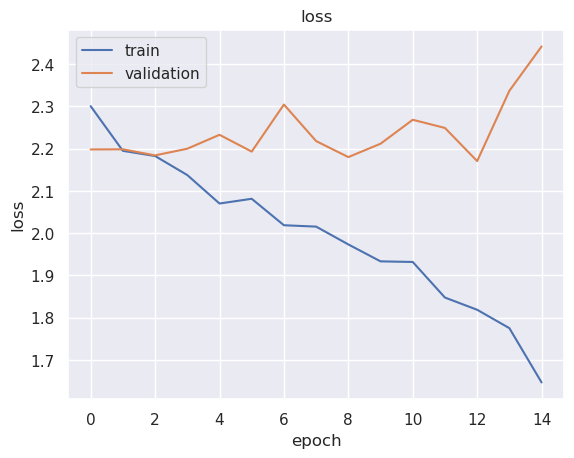

In [15]:
sns.set()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

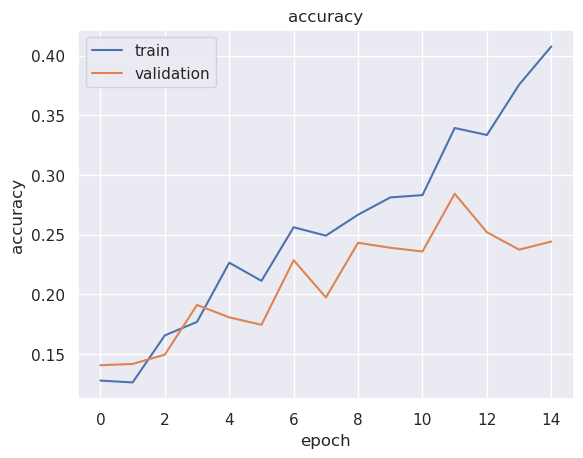

In [16]:
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='validation')
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

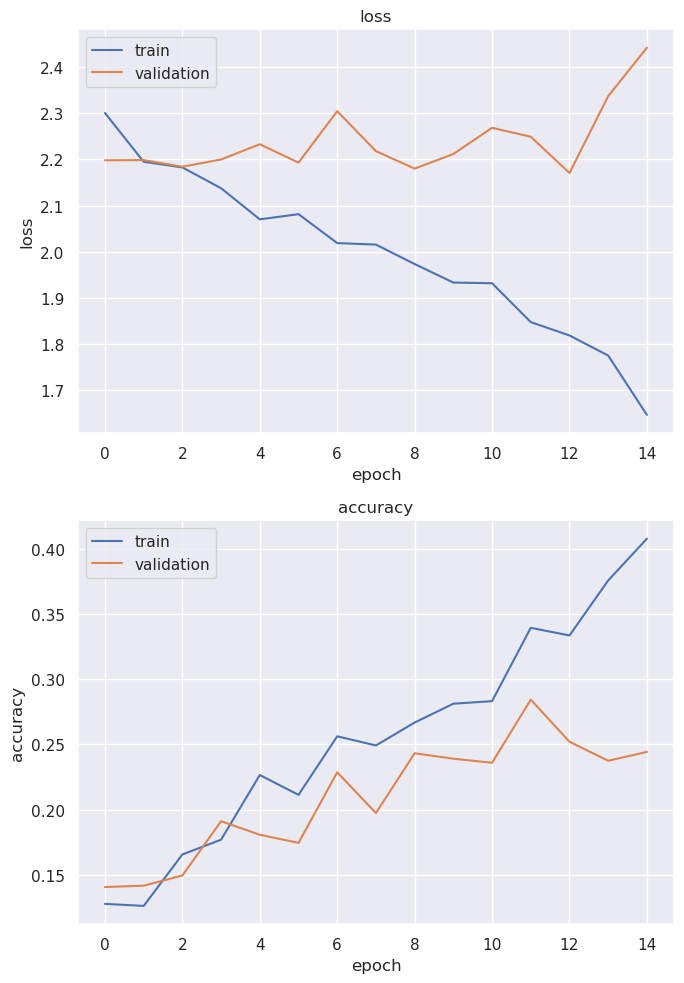

In [21]:
plot_data = {
    'loss': {'train': train_losses, 'val': val_losses},
    'accuracy': {'train': train_accs, 'val': val_accs},
}

sns.set()
plot_num = len(plot_data)
fig, axes = plt.subplots(plot_num, 1, figsize=(7, 5*plot_num))

for ax, (title, data_dict) in zip(axes, plot_data.items()):
    ax.plot(data_dict['train'], label='train')
    ax.plot(data_dict['val'], label='validation')
    ax.set_title(title)
    ax.set_xlabel('epoch')
    ax.set_ylabel(title)
    ax.legend()

plt.tight_layout()
fig.savefig('result.png')